In [94]:
import h5py
import illustris_python.groupcat as gc
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
import corner
import scipy.special
%matplotlib inline

In [95]:
filename = "../data/pairs_box_L205n2500TNG.hdf5"
f = h5py.File(filename, 'r')
keys = list(f.keys())
pair_data = {}
for k in keys:
    pair_data[k] = f[k][...]
print(keys)
f.close()
print(pair_data['hubble'])

['halo_mass_A', 'halo_mass_B', 'halo_mass_G', 'hubble', 'pos_A', 'pos_B', 'pos_G', 'stellar_mass_A', 'stellar_mass_B', 'stellar_mass_G', 'subhalo_ID_A', 'subhalo_ID_B', 'subhalo_ID_G', 'vel_A', 'vel_B', 'vel_G', 'vmax_A', 'vmax_B', 'vmax_G']
0.6774


In [96]:
pair_data['vel_A_mag'] = np.sqrt(np.sum(pair_data['vel_A']**2, axis=1))
pair_data['vel_B_mag'] = np.sqrt(np.sum(pair_data['vel_B']**2, axis=1))
pair_data['vel_G_mag'] = np.sqrt(np.sum(pair_data['vel_G']**2, axis=1))

pair_data['pos_AB'] = np.sqrt(np.sum( (pair_data['pos_B'] - pair_data['pos_A'])**2, axis=1))
pair_data['vel_AB'] = np.sqrt(np.sum( (pair_data['vel_B'] - pair_data['vel_A'])**2, axis=1)) # comoving
pair_data['vel_AB_rad'] = np.sum((pair_data['pos_B'] - pair_data['pos_A'])*(pair_data['vel_B'] - pair_data['vel_A']), axis=1)/pair_data['pos_AB'] #comoving
pair_data['vel_AB_tan'] = np.sqrt((pair_data['vel_AB']**2 - pair_data['vel_AB_rad']**2))# comoving
    
#now we compute the radial velocity including the hubble flow, positions are in kpc
pair_data['vel_AB_rad'] = pair_data['vel_AB_rad'] + (pair_data['pos_AB']/1000 * pair_data['hubble']*100)

# here we compute the compute the dot product between the position vector and the radial velocity
pair_data['mu'] = np.abs(np.sum((pair_data['pos_B']-pair_data['pos_A'])*(pair_data['vel_B']), axis=1)/(pair_data['vel_B_mag']*pair_data['pos_AB']))

In [97]:
obs = {}
obs['pos_AB'] = 780
obs['vel_AB_rad'] = -110.0
obs['vel_AB_tan'] = 55.0 

obs['delta_pos_AB'] = 80.0
obs['delta_vel_AB_rad'] = 10.0
obs['delta_vel_AB_tan'] = 5.0 

n_delta = 10
bins = {}
for k in ['pos_AB', 'vel_AB_rad', 'vel_AB_tan']:
    bins[k] = np.linspace(obs[k]-n_delta*obs['delta_'+k], obs[k]+n_delta*obs['delta_'+k], n_delta*2 +1)

print(bins['pos_AB'])
print(bins['vel_AB_rad'])
print(bins['vel_AB_tan'])

[ -20.   60.  140.  220.  300.  380.  460.  540.  620.  700.  780.  860.
  940. 1020. 1100. 1180. 1260. 1340. 1420. 1500. 1580.]
[-210. -200. -190. -180. -170. -160. -150. -140. -130. -120. -110. -100.
  -90.  -80.  -70.  -60.  -50.  -40.  -30.  -20.  -10.]
[  5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.
  75.  80.  85.  90.  95. 100. 105.]


In [106]:
counts = np.zeros((2*n_delta+1, 2*n_delta+1, 2*n_delta+1))
i_delta = 3.0
for ii in range(2*n_delta+1):
    for jj in range(2*n_delta+1):
        for kk in range(2*n_delta+1):
            ii_in = pair_data['pos_AB'] > (bins['pos_AB'][ii]-i_delta*obs['delta_pos_AB'])
            ii_in &= pair_data['pos_AB'] < (bins['pos_AB'][ii]+ i_delta*obs['delta_pos_AB'])
            ii_in &= pair_data['vel_AB_rad'] > (bins['vel_AB_rad'][jj]- i_delta * obs['delta_vel_AB_rad'])
            ii_in &= pair_data['vel_AB_rad'] < (bins['vel_AB_rad'][jj]+ i_delta * obs['delta_vel_AB_rad'])
            ii_in &= pair_data['vel_AB_tan'] > (bins['vel_AB_tan'][kk]- i_delta * obs['delta_vel_AB_tan'])
            ii_in &= pair_data['vel_AB_tan'] < (bins['vel_AB_tan'][kk] + i_delta * obs['delta_vel_AB_tan'])
            counts[ii,jj,kk] = np.count_nonzero(ii_in)

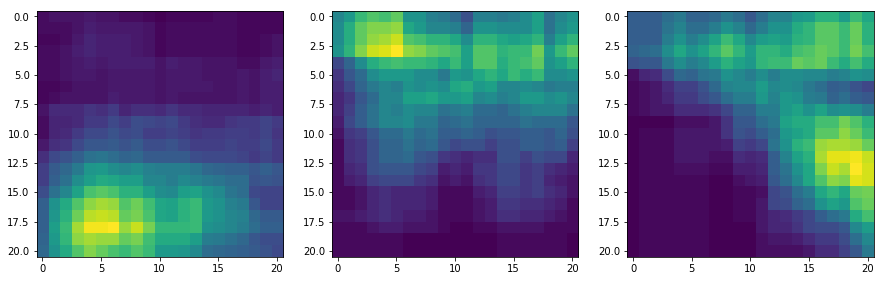

In [107]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(counts[10,:,:])

plt.subplot(1,3,2)
plt.imshow(counts[:,10,:])

plt.subplot(1,3,3)
plt.imshow(counts[:,:,10])

In [108]:
print(counts[10,10,10])
print(counts.max())

11.0
79.0


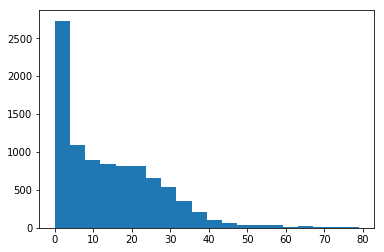

In [109]:
_ = plt.hist(counts.flatten(), bins=20)

In [110]:
max_tuple = np.unravel_index(np.argmax(counts), ((2*n_delta+1, 2*n_delta+1, 2*n_delta+1)))
print(max_tuple, bins['pos_AB'][max_tuple[0]], bins['vel_AB_rad'][max_tuple[1]], bins['vel_AB_tan'][max_tuple[2]])

(14, 20, 5) 1100.0 -10.0 30.0


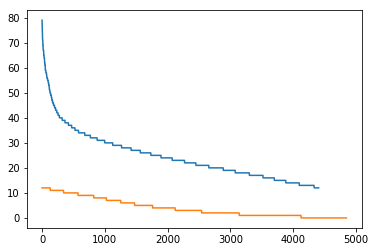

In [135]:
sorted_counts = np.sort(counts.flatten())[::-1]
cum_sorted_counts = np.cumsum(sorted_counts)
#plt.plot(cum_sorted_counts/np.sum(sorted_counts) )
ii = (cum_sorted_counts/np.sum(sorted_counts)) <0.85
plt.plot(sorted_counts[ii])
ii = cum_sorted_counts/np.sum(sorted_counts) >0.85
plt.plot(sorted_counts[ii])